### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

$$L(z, y_i) = (y_i - z) ^ 2,~\frac{\partial L}{\partial z} = -2(y_i - z),~\left.-\frac{\partial L}{\partial z}\right\vert_{\large z=F_{k-1}(x_i)}=2(y_i - F_{k-1}(x_i))$$

$$L(z, y_i) = e^{\large -zy_i},~\frac{\partial L}{\partial z}=-y_ie^{\large -zy_i},~\left.-\frac{\partial L}{\partial z}\right\vert_{\large z=F_{k-1}(x_i)}=y_ie^{\large -y_iF_{k-1}(x_i)}$$

$$L(z, y_i) = \log(1 + e^{\large -zy_i}),~\frac{\partial L}{\partial z}=-y_i\frac{e^{\large -zy_i}}{1 + e^{\large -zy_i}},~\left.-\frac{\partial L}{\partial z}\right\vert_{\large z=F_{k-1}(x_i)}=y_i\frac{e^{\large -y_iF_{k-1}(x_i)}}{1 + e^{\large -y_iF_{k-1}(x_i)}}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
from typing import Callable
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from scipy.optimize import minimize

# for results reproducing
np.random.seed(42)

In [2]:
class MyGradientBoostingClassifier:
    def __init__(
        self,
        loss: str = 'mse', learning_rate: float = 0.1, n_estimators: int = 100, 
        colsample: float = 1.0, subsample: float = 1.0,
        *args, **kwargs
    ):
        """
        loss -- один из 3 лоссов: 'mse', 'exp', 'log'
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучении одного алгоритма
        colsample -- процент рандомных объектов при обучении одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        if loss not in ['mse', 'exp', 'log']:
            raise ValueError(f"Bad loss: {loss}")

        self.base_model_args = args
        self.base_model_kwargs = kwargs
        
        self.loss = loss
        self.lr = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        
        self.models = []
        self.gammas = []
    
    def _bootstrap_idx(self, train: np.ndarray):
        n_objects, n_features = train.shape
        samples_idx = np.random.permutation(n_objects)[:int(self.subsample * n_objects)]
        features_idx = np.random.permutation(n_features)[:int(self.colsample * n_features)]
        return samples_idx, features_idx
    
    def _find_optimal_gamma(self, y: np.array, old_predictions: np.array, new_predictions: np.array) -> float:
        """
        y -- таргеты для обучения
        """
        def min_func(gamma):
            if self.loss == 'mse':
                return ((y - (old_predictions + gamma * new_predictions)) ** 2).mean()
            elif self.loss == 'exp':
                return np.exp(-(old_predictions + gamma * new_predictions) * y).mean()
            elif self.loss == 'log':
                return np.log(1 + np.exp(-(old_predictions + gamma * new_predictions) * y)).mean()
        
        return minimize(min_func, x0=0.5).x
    
    def _fit_base_model(self, x: np.ndarray, y: np.array, base_model_cls: Callable):
        """
        x -- объекты для обучения:
        y -- таргеты для обучения
        """
        base_model = base_model_cls(*self.base_model_args, **self.base_model_kwargs)
        base_model.fit(x, y)
        return base_model
    
    def _rescale(self, y: np.ndarray):
        """
        scale target to [-1, 1]
        """
        return (self.min + self.max - 2 * y) / (self.min - self.max)
    
    def _rescale_back(self, predicts: np.ndarray):
        pred_min, pred_max = np.min(predicts), np.max(predicts)
        k = (self.min - self.max) / (pred_min - pred_max)
        b = (self.max * pred_min - self.min * pred_max) / (pred_min - pred_max)
        return k * predicts + b
    
    def fit(self, x_src, y_src, base_model_cls=DecisionTreeRegressor, init_model=None):
        """
        x -- объекты для обучения
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        x = x_src.copy()
        
        self.min = np.min(y_src)
        self.max = np.max(y_src)
        y = self._rescale(y_src)
        
        base_model = DummyRegressor() if init_model is None else init_model
        base_model.fit(x, y)
        base_model.features_idx = np.arange(x.shape[1])
        self.models.append(base_model)
        self.gammas.append(1.0)

        for i in range(1, self.n_estimators):
            old_preds = self._predict(x)
            
            new_targets = None
            if self.loss == 'mse':
                new_targets = 2 * (y - old_preds)
            elif self.loss == 'exp':
                new_targets = y * np.exp(-old_preds * y)
            elif self.loss == 'log':
                exp = np.exp(-old_preds * y)
                new_targets = y * exp / (1 + exp)
            
            samples_idx, features_idx = self._bootstrap_idx(x)

            base_model = self._fit_base_model(
                x[samples_idx, :][:, features_idx],
                new_targets[samples_idx], 
                base_model_cls
            )
            base_model.features_idx = features_idx
            
            gamma = self._find_optimal_gamma(y, old_preds, base_model.predict(x[:, features_idx]))

            self.models.append(base_model)
            self.gammas.append(gamma)

        return self
    
    def _predict(self, x):
        predicts = np.zeros((x.shape[0]))
        for gamma, base_model in zip(self.gammas, self.models):
            predicts += self.lr * gamma * base_model.predict(x[:, base_model.features_idx])
        return predicts
    
    def predict(self, x):
        return np.round(self._rescale_back(self._predict(x))).astype(int)

In [3]:
my_clf = MyGradientBoostingClassifier(max_depth=3)
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target,
    test_size=0.1,
    stratify=wine.target
)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовать разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [9]:
clf = MyGradientBoostingClassifier()
clf.fit(X_train, y_train)
print(f"initial accuracy: {accuracy_score(y_pred=clf.predict(X_val), y_true=y_val)}")

initial accuracy: 0.8265503875968992


###  Точность в зависимости от числа итераций на валидации

In [10]:
estimators = range(10, 160, 10)
estimators_scores = []
for n_estimators in tqdm(estimators):
    clf = MyGradientBoostingClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    estimators_scores.append(accuracy_score(y_pred=clf.predict(X_val), y_true=y_val))

best_n_estimators = estimators[np.argmax(estimators_scores)]
print(f"Best n_estimators: {best_n_estimators}")

100%|███████████████████████████████████████████| 15/15 [04:09<00:00, 16.65s/it]

Best n_estimators: 50


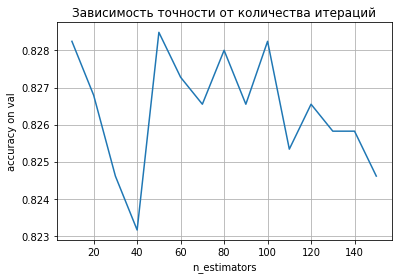

In [11]:
plt.xlabel("n_estimators")
plt.ylabel("accuracy on val")
plt.title("Зависимость точности от количества итераций")
plt.plot(estimators, estimators_scores)
plt.grid(True)

### Подбор оптимальных параметров на валидации

### loss

In [12]:
losses = ['mse', 'exp', 'log']
losses_scores = []
for loss in tqdm(losses):
    clf = MyGradientBoostingClassifier(loss=loss)
    clf.fit(X_train, y_train)
    losses_scores.append(accuracy_score(y_pred=clf.predict(X_val), y_true=y_val))

best_loss = losses[np.argmax(losses_scores)]
print(f"Best loss: {best_loss}")

100%|█████████████████████████████████████████████| 3/3 [01:01<00:00, 20.41s/it]

Best loss: log


### learning rate

In [13]:
lrs = np.arange(0.1, 0.6, 0.1)
lr_scores = []
for lr in tqdm(lrs):
    clf = MyGradientBoostingClassifier(learning_rate=lr)
    clf.fit(X_train, y_train)
    lr_scores.append(accuracy_score(y_pred=clf.predict(X_val), y_true=y_val))

best_lr = lrs[np.argmax(lr_scores)]
print(f"Best learning rate: {best_lr}")

100%|█████████████████████████████████████████████| 5/5 [01:11<00:00, 14.36s/it]

Best learning rate: 0.2


### colsample

In [14]:
colsamples = np.linspace(1/8, 1.0, 8)
colsamples_scores = []
for colsample in tqdm(colsamples):
    clf = MyGradientBoostingClassifier(colsample=colsample)
    clf.fit(X_train, y_train)
    colsamples_scores.append(accuracy_score(y_pred=clf.predict(X_val), y_true=y_val))

best_colsample = colsamples[np.argmax(colsamples_scores)]
print(f"Best colsample: {best_colsample}")

100%|█████████████████████████████████████████████| 8/8 [02:23<00:00, 17.97s/it]

Best colsample: 0.75


### subsample

In [15]:
subsamples = np.linspace(0.3, 1.0, 8)
subsamples_scores = []
for subsample in tqdm(subsamples):
    clf = MyGradientBoostingClassifier(subsample=subsample)
    clf.fit(X_train, y_train)
    subsamples_scores.append(accuracy_score(y_pred=clf.predict(X_val), y_true=y_val))

best_subsample = subsamples[np.argmax(subsamples_scores)]
print(f"Best subsample: {best_subsample}")

100%|█████████████████████████████████████████████| 8/8 [03:53<00:00, 29.21s/it]

Best subsample: 0.39999999999999997


### max depth

In [16]:
max_depths = range(3, 10)
max_depths_scores = []
for max_depth in tqdm(max_depths):
    clf = MyGradientBoostingClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    max_depths_scores.append(accuracy_score(y_pred=clf.predict(X_val), y_true=y_val))

best_max_depth = max_depths[np.argmax(max_depths_scores)]
print(f"Best max depth: {best_max_depth}")

100%|█████████████████████████████████████████████| 7/7 [01:06<00:00,  9.56s/it]

Best max depth: 7


### Качество на подобранных параметрах

In [17]:
best_params = {
    "n_estimators": best_n_estimators,
    "loss": best_loss,
    "learning_rate": best_lr,
    "colsample": best_colsample,
    "subsample": best_subsample,
    "max_depth": best_max_depth
}
best_params

{'n_estimators': 50,
 'loss': 'log',
 'learning_rate': 0.2,
 'colsample': 0.75,
 'subsample': 0.39999999999999997,
 'max_depth': 7}

In [18]:
clf = MyGradientBoostingClassifier(**best_params)
clf.fit(X_train, y_train)
print(f"accuracy: {accuracy_score(y_pred=clf.predict(X_val), y_true=y_val)}")

accuracy: 0.8888081395348837


## BooBag BagBoo (1 балл)

Попробуем объединить бустинг и бэггинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [19]:
# RandomForest as base model

clf = MyGradientBoostingClassifier(n_estimators=10)
clf.fit(X_train, y_train, base_model_cls=RandomForestRegressor)
print(f"accuracy: {accuracy_score(y_pred=clf.predict(X_val), y_true=y_val)}")

accuracy: 0.8817829457364341


In [20]:
# Bagging on gradient boosting machines

n_classifiers = 10
classifiers = [MyGradientBoostingClassifier() for _ in range(n_classifiers)]
for clf in classifiers:
    samples_idx = np.random.permutation(X_train.shape[0])[:X_train.shape[0] // 2]
    clf.fit(X_train[samples_idx, :], y_train[samples_idx])

prediction = np.zeros(X_val.shape[0])
for clf in classifiers:
    prediction += clf.predict(X_val)
prediction /= len(classifiers)
prediction = np.round(prediction)

print(f"accuracy: {accuracy_score(y_pred=prediction, y_true=y_val)}")

accuracy: 0.8684593023255814


В случае бустинга над случайными лесами качество увеличилось засчет того, что первый обученный случайный лес уже выдавал предсказание сильно лучше, чем одно единственное дерево решений:

In [21]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
print(f"accuracy: {accuracy_score(y_pred=np.round(reg.predict(X_val)), y_true=y_val)}")

accuracy: 0.877422480620155


В случае же бэггинга над бустингами, срабатывает идея бэггинга: ансамблирование большого числа слабых моделей увеличивает качество

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [22]:
models = [RandomForestRegressor(), SGDRegressor()]
models_names = ["RandomForest", "Linear regression"]
models_scores = []
for model in tqdm(models):
    clf = MyGradientBoostingClassifier(n_estimators=10)
    clf.fit(X_train, y_train, init_model=model)
    models_scores.append(accuracy_score(y_pred=clf.predict(X_val), y_true=y_val))

print(f"Best init model: {models[np.argmax(models_scores)]}")

100%|█████████████████████████████████████████████| 2/2 [00:10<00:00,  5.44s/it]

Best init model: RandomForestRegressor()


In [23]:
pd.DataFrame({"models": models_names, "scores": models_scores})

,models,scores
0,RandomForest,0.823886
1,Linear regression,0.577762


Да, качество увеличилось при использовании сильной начальной модели (случайный лес), при использовании же неподходящей для задачи модели (линейной), наблюдается уменьшение точности.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

